In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load parquet files
df = pd.read_parquet('analytics_3714b913_68f5_44eb_8cfc_a3e6955f3ab8.mvt_combo_line.parquet')
#df = pd.read_parquet('analytics_ebaca63c_96a9_490a_a7da_e1eb6f7f3f0c.mvt_combo_line.parquet')
#df = pd.read_parquet('analytics_f3dc8773_d687_47b9_887d_6442c32d155c.mvt_combo_line.parquet')
#df = pd.read_parquet('analytics_fb5f05dd_74c6_41b7_bd8c_16bd1459d40b.mvt_combo_line.parquet')

* document_class (3=invoice, 4=return)
* extended_cost (unique cost of item times volume sold, line specific)
* extended_price (line specific, zero means discount or was not tracked)
* item_number (one-to-one mapping to item_description, used for data analysis)
* uofm (unit of measure)

In [57]:
df['date_column'] = pd.to_datetime(df['doc_date'], unit='s')

In [58]:
df.columns

Index(['base_quantity', 'base_unit_cost', 'base_unit_price',
       'customer_account_status', 'customer_class', 'customer_id',
       'customer_name', 'customer_number', 'customer_sales_person_code',
       'customer_sales_person', 'discount', 'discount_amount', 'doc_date',
       'doc_external_id', 'doc_shipto_code', 'doc_shipto_display_name',
       'document_class', 'document_id', 'extended_cost', 'extended_price',
       'external_number', 'item_category_code', 'item_class',
       'item_description', 'item_number', 'item_type', 'item_vendor_item_no',
       'item_vendor_no', 'line_description', 'line_external_id', 'line_id',
       'line_markdown_amount', 'line_shipto_code', 'line_shipto_display_name',
       'line_warehouse_id', 'line_warehouse', 'markdown_percent',
       'price_level_id', 'quantity', 'sales_rep_id', 'sales_rep_name',
       'sales_territory_id', 'sales_territory', 'subtotal',
       'subtotal_net_discount', 'unit_cost', 'unit_price', 'uofm',
       'warehouse_

In [59]:
df.shape

(822531, 51)

In [60]:
df[['document_id', 'extended_cost', 'unit_price', 'quantity', 'discount', 'discount_amount']].head(10)

,document_id,extended_cost,unit_price,quantity,discount,discount_amount
0,6979110290205437753,13.17000,24.10000,3.00000,0.00000,0.00000
1,6979110290205437753,0.00000,0.00000,1.00000,0.00000,0.00000
2,6979189566224506628,0.00000,0.00000,1.00000,0.00000,0.00000
3,6979189566224506628,15.25000,57.56000,1.00000,0.00000,0.00000
4,6979189566224506628,0.00000,0.00000,1.00000,0.00000,0.00000
5,6979394791520167563,13.18000,13.33000,3.00000,0.00000,0.00000
6,6979552102177334788,19.62000,5.67000,10.00000,0.00000,0.00000
7,6979552102177334788,29.26000,69.95000,2.00000,0.00000,0.00000
8,6979552102177334788,0.00000,0.00000,1.00000,0.00000,0.00000
9,6979552102177334788,27.27000,45.96000,1.00000,0.00000,0.00000


## Basic column calculations

In [61]:
# Year
df['year'] = df['date_column'].dt.year

# Month
df['month'] = df['date_column'].dt.month

# Revenue
df['revenue'] =  df['quantity'] * df['unit_price']

In [62]:
# Basic Summarization
basic = df.groupby(['year', 'month']).agg({'revenue': 'sum', 'quantity': 'sum', 'unit_price': 'mean', 'discount': 'mean',
                                           'item_number': 'nunique', 'customer_id': 'nunique', 'document_id': 'nunique'}).sort_index()

# Add index column from 1 to n
basic['index'] = range(1, len(basic) + 1)

Somehow, need to make new features that describe invoice trends: 
- number of important purchases
- skew of purchases
- rare purchases
- recurrent purchases
  - group items by customer per month. make item in future months the target variable
- entropy scores for customers
- customer frequency summarization
  - customers with the most purchases: how often did they make purchases? how many separate days did they make a purchse?
- flag customer churn patterns
  - identify the last purchase of every customer i nthe entire dataset
  - filter for customers that have not made a purchase in a long time
  - identify the patterns of their purchases
  - make a conditional/bayesian estimation of the likelihood that they will churn
- market-basket-analysis of products.
- use the same type of processwith the item baskets and recurrent purchases to find if there are other parameters (price, quntity, time...) that are associated with future purchases.
- cumulative sum of unique customers, maybe also churn rate

## Entropy and Skew

In [63]:
# Skew
skew = df.groupby(['year', 'month']).agg({'revenue': 'skew', 'quantity': 'skew', 'unit_price': 'skew', 'discount': 'skew'}).sort_index()

# Rename columns to have 'skew' suffix
skew.columns = [f'{col}_skew' for col in skew.columns]

# Define entropy
def entropy(x):
    p = np.array(x.value_counts(normalize=True))
    return -np.sum(p * np.log2(p))

# Entropy to every column
entropy = df.groupby(['year', 'month']).agg({'revenue': entropy, 'quantity': entropy, 'unit_price': entropy, 'discount': entropy,
                                             'customer_id': entropy, 'item_number': entropy, 'document_id': entropy}).sort_index()

# Rename columns to have 'entropy' suffix
entropy.columns = [f'{col}_entropy' for col in entropy.columns]

# Unique purchases

In [64]:
# Ensure 'unit_price' and 'quantity' columns are numeric
df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

# High priced purchases
high_priced_mask = df['unit_price'] > df['unit_price'].quantile(0.90)
df['high_priced'] = high_priced_mask

# High quantity purchases
high_quantity_mask = df['quantity'] > df['quantity'].quantile(0.90)
df['high_quantity'] = high_quantity_mask

# Group by year and month
rare_purchases = df.groupby(['year', 'month']).agg({'high_priced': 'sum', 'high_quantity': 'sum'}).sort_index()

# Apriori of items

In [65]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Create baskets of item_number by year, month, and customer_id
basket = df.groupby(['year', 'month', 'customer_id'])['item_description'].apply(list).reset_index()

# Index column
months = basket.groupby(['year', 'month']).size().reset_index()
months['index'] = range(1, len(months) + 1)

# Merge index column to baskets
basket = basket.merge(months[['year', 'month', 'index']], on=['year', 'month'], how='left')
basket = basket.drop(['year', 'month'], axis=1)
basket = basket.rename(columns={'item_description': 'item_basket'})

# Sample baskets
b = basket.sample(frac=0.25, random_state=1)

# One-hot encode the item_basket and item_basket_target
baskets_encoded = b['item_basket'].str.join('|').str.get_dummies()

# Frequent itemsets
frequent_itemsets = apriori(baskets_encoded, min_support=0.01, use_colnames=True)

# Association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules.sort_values('lift', ascending=False).head(10)

c:\Users\Jack\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
28,(Refrigerator),(Multifunctional Fabric Refrigerator),0.028897,0.051254,0.013951,0.482780,9.419396,0.012470,1.834318,0.920434
29,(Multifunctional Fabric Refrigerator),(Refrigerator),0.051254,0.028897,0.013951,0.272191,9.419396,0.012470,1.334284,0.942123
109,(Vanity),"(Saffron Rug, Decorative, Red Pet Food Bowl)",0.492420,0.016581,0.012902,0.026202,1.580225,0.004737,1.009880,0.723392
108,"(Saffron Rug, Decorative, Red Pet Food Bowl)",(Vanity),0.016581,0.492420,0.012902,0.778135,1.580225,0.004737,2.287787,0.373370
99,(Vanity),"(Purple Silk Refrigerator, Red Pet Food Bowl)",0.492420,0.019531,0.014413,0.029270,1.498605,0.004795,1.010032,0.655489
98,"(Purple Silk Refrigerator, Red Pet Food Bowl)",(Vanity),0.019531,0.492420,0.014413,0.737944,1.498605,0.004795,1.936910,0.339340
76,"(High-End Microwave, Red Pet Food Bowl)",(Vanity),0.032149,0.492420,0.023441,0.729132,1.480711,0.007610,1.873901,0.335433
77,(Vanity),"(High-End Microwave, Red Pet Food Bowl)",0.492420,0.032149,0.023441,0.047604,1.480711,0.007610,1.016227,0.639601
101,(Red Pet Food Bowl),"(Vanity, Purple Silk Refrigerator)",0.531856,0.018500,0.014413,0.027099,1.464793,0.004573,1.008838,0.677803
96,"(Vanity, Purple Silk Refrigerator)",(Red Pet Food Bowl),0.018500,0.531856,0.014413,0.779059,1.464793,0.004573,2.118861,0.323291


In [66]:
# High lift
rules['high_lift'] = rules['lift'] > rules['lift'].quantile(0.5)
high_lift = rules[rules['high_lift']]

# Extract antecedents and convert to strings
high_lift_antecedents = high_lift['antecedents'].apply(lambda x: list(x)[0])

# Add to df
df['high_lift'] = df['item_description'].isin(high_lift_antecedents)

# Group by year and month and aggregate high_lift
lift = df.groupby(['year', 'month']).agg({'high_lift': 'sum'}).sort_index()

# Recurrent purchases

In [67]:
# Create baskets of item_description by year, month, and customer_id
basket = df.groupby(['year', 'month', 'customer_id'])['item_description'].apply(list).reset_index()

# Index column
months = basket.groupby(['year', 'month']).size().reset_index()
months['index'] = range(1, len(months) + 1)

# Merge index column to baskets
basket = basket.merge(months[['year', 'month', 'index']], on=['year', 'month'], how='left')
basket = basket.drop(['year', 'month'], axis=1)
basket = basket.rename(columns={'item_description': 'item_basket'})

# Create target variable
basket_target = basket.copy()
basket_target['index'] = basket_target['index'] - 1
basket_target = basket_target.rename(columns={'item_basket': 'item_basket_target'})

# Merge target variable to baskets on index and customer_id
basket = basket.merge(basket_target, on=['index', 'customer_id'], how='left')

# Sample baskets
baskets = basket.sample(frac=0.25, random_state=1)

# Flag when there was no future purchase
baskets['flag'] = baskets['item_basket_target'].isnull()

# Separate into recurrent and null
recurrent = baskets[~baskets['flag']]
null = baskets[baskets['flag']]

# One-hot encode the item_basket
recurrent_encoded = recurrent['item_basket'].str.join('|').str.get_dummies()
null_encoded = null['item_basket'].str.join('|').str.get_dummies()

# Value counts of recurrent and null item_baskets
r_value_counts = recurrent_encoded.sum().sort_values(ascending=False)
n_value_counts = null_encoded.sum().sort_values(ascending=False)

from scipy.stats import chi2_contingency
# Create a contingency table
contingency_table = pd.DataFrame({
    'Recurrent': r_value_counts,
    'Null': n_value_counts
}).fillna(0)

# Perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square statistic: 8392.795912887073
P-value: 0.0
Degrees of freedom: 1308


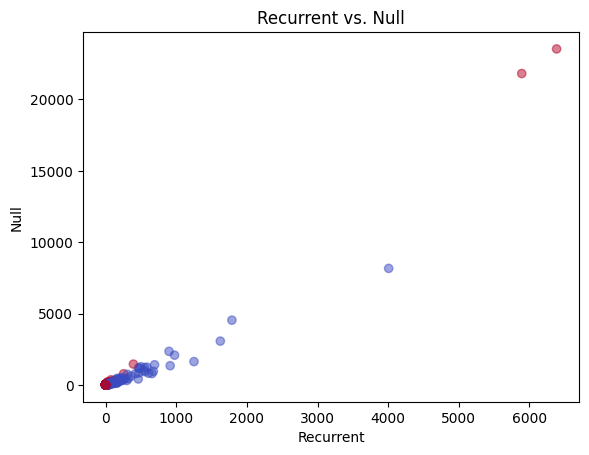

In [68]:
from scipy.stats import chi2

# Calculate the chi-squared statistic
contingency_table['chi_squared'] = (contingency_table['Null'] - contingency_table['Recurrent'])**2 / contingency_table['Recurrent']

# Degrees of freedom for each row
contingency_table['dof'] = contingency_table['Recurrent'] + contingency_table['Null'] - 1

# 95th quantile of chi-squared distribution given the degrees of freedom
contingency_table = contingency_table[contingency_table['dof'] > 0]
contingency_table['chi_squared_quantile'] = chi2.ppf(0.05, contingency_table['dof'])

# Significance
contingency_table['significance'] = contingency_table['chi_squared'] > contingency_table['chi_squared_quantile']

# Recurrent_purchase 
contingency_table['recurrent_purchase'] = contingency_table['significance'] & (contingency_table['Recurrent'] - contingency_table['Null'] > 0)

# One_time_purchase
contingency_table['one_time_purchase'] = contingency_table['significance'] & (contingency_table['Null'] - contingency_table['Recurrent'] > 0)

# Chance of recurrent purchase
contingency_table['chance_recurrent'] = contingency_table['Recurrent'] / (contingency_table['Recurrent'] + contingency_table['Null'])

# Scatter of recurrent and null
plt.scatter(contingency_table['Recurrent'], contingency_table['Null'], c=contingency_table['significance'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Recurrent')
plt.ylabel('Null')
plt.title('Recurrent vs. Null')
plt.show()

In [69]:
contingency_table.shape

(931, 9)

In [70]:
# Recurrent purchases
recurrent_purchases = contingency_table[contingency_table['recurrent_purchase'] == True].index

# One-time purchases
one_time_purchases = contingency_table[contingency_table['one_time_purchase'] == True].index

# Chance of recurrent purchase
df = df.merge(contingency_table[['chance_recurrent']].head(50), left_on='item_description', right_index=True, how='left')

# Create columns
df['recurrent_purchase'] = df['item_description'].isin(recurrent_purchases)
df['one_time_purchase'] = df['item_description'].isin(one_time_purchases)

# Group by year and month
purchases = df.groupby(['year', 'month']).agg({'recurrent_purchase': 'sum', 'one_time_purchase': 'sum', 
                                               'chance_recurrent': 'mean'}).sort_index()

In [71]:
# Combine the saved dataframes
total = pd.concat([basic, skew, entropy, rare_purchases, purchases, lift], axis=1)

# Save df
total.to_csv('transformed_371.csv', index=True)
total.head()

revenue     quantity unit_price discount  item_number  \
year month                                                                    
2013 1      440655.7250000000  39069.00000   31.02055      0.0          253   
     2      376620.8850000000  33120.00000  32.618998      0.0          247   
     3      395506.5300000000  41112.00000  29.558159      0.0          278   
     4      443267.0520000000  35320.00000  30.286281      0.0          278   
     5      502755.4900000000  42051.00000  31.821201      0.0          366   

            customer_id  document_id  index revenue_skew quantity_skew  ...  \
year month                                                              ...   
2013 1             1291         1639      1    10.197171     19.684809  ...   
     2             1173         1435      2     9.238132     24.020405  ...   
     3             1173         1443      3    10.505197      28.54082  ...   
     4             1204         1592      4    17.013619      16.71443  ...   
     5             1332         1680      5     8.669743     35.036738  ...   

           discount_entropy customer_id_entropy  item_number_entropy  \
year month                                                             
2013 1                 -0.0            9.997103             6.010735   
     2                 -0.0            9.794298             6.237180   
     3                 -0.0            9.869265             6.196558   
     4                 -0.0            9.912832             5.895749   
     5                 -0.0           10.030326             6.161299   

            document_id_entropy  high_priced  high_quantity  \
year month                                                    
2013 1                10.476548          161            359   
     2                10.246280          116            375   
     3                10.243339          160            374   
     4                10.408360          189            355   
     5                10.476226          217            393   

            recurrent_purchase  one_time_purchase  chance_recurrent  high_lift  
year month                                                                      
2013 1                       3                523          0.267027       1306  
     2                       3                346          0.357792        953  
     3                       1                635          0.334408       1127  
     4                       2                814          0.308857       1532  
     5                       4                733          0.285477       1513  

[5 rows x 25 columns]